In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft as swyft

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None):
        super().__init__()
        self.on_after_forward = swyft.to_numpy32
        
    def forward(self, trace):
        z = trace.sample('z', np.random.rand, 3)
        x = trace.sample('x', lambda z: z + np.random.randn(3)*0.02, z)

In [4]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.classifier = swyft.RatioEstimatorMLP1d(3, 3)
        
    def forward(self, A, B):
        x = A['x']
        z = B['z']
        ratios_z = self.classifier(x, z)
        return dict(z = ratios_z)

In [5]:
simulator = Simulator()
samples = simulator(10000)

AttributeError: 'int' object has no attribute 'sample'

In [6]:
dl_train = samples[:8000].get_dataloader(batch_size = 128, shuffle = True)
dl_valid = samples[8000:9000].get_dataloader(batch_size = 128)
dl_test = samples[9000:].get_dataloader(batch_size = 128)

In [7]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
network = Network()

In [9]:
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                | Params
---------------------------------------------------
0 | classifier | RatioEstimatorMLP1d | 52.6 K
---------------------------------------------------
52.6 K    Trainable params
0         Non-trainable params
52.6 K    Total params
0.210     Total estimated model params size (MB)
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/weniger/codes/swyft/notebooks/lightning_logs/version_9748326/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  89%|████████▊ | 63/71 [00:00<00:00, 92.44it/s, loss=-3.02, v_num=9748326] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  89%|████████▊ | 63/71 [00:00<00:00, 90.08it/s, loss=-3.07, v_num=9748326, val_loss=-2.91]
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▊ | 63/71 [00:00<00:00, 94.08it/s, loss=-3.16, v_num=9748326, val_loss=-3.03]
Validating: 0it [00:00, ?it/s]
Epoch 3:  89%|████████▊ | 63/71 [00:00<00:00, 95.58it/s, loss=-3.11, v_num=9748326, val_loss=-2.98] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  89%|████████▊ | 63/71 [00:00<00:00, 92.88it/s, loss=-3.09, v_num=9748326, val_loss=-3.08] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  89%|████████▊ | 63/71 [00:00<00:00, 101.43it/s, loss=-3.09, v_num=9748326, val_loss=-3.13]
Validating: 0it [00:00, ?it/s]
Epoch 6:  89%|████████▊ | 63/71 [00:00<00:00, 94.63it/s, loss=-3.1, v_num=9748326, val_loss=-3.11]  
Validating: 0it [00:00, ?it/s]
Epoch 7:  89%|████████▊ | 63/71 [00:00<00:00, 98.18it/s, loss=-3.1, v_num=9748326, val_loss=-2

In [10]:
trainer.test(network, dl_test, ckpt_path = 'best')

Restoring states from the checkpoint path at /home/weniger/codes/swyft/notebooks/lightning_logs/version_9748326/checkpoints/epoch=9-step=629.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/weniger/codes/swyft/notebooks/lightning_logs/version_9748326/checkpoints/epoch=9-step=629.ckpt
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': -3.11047101020813, 'hp/KL-div': -7.5274224281311035}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 8/8 [00:00<00:00, 189.73it/s]


[{'hp/JS-div': -3.11047101020813, 'hp/KL-div': -7.5274224281311035}]

In [11]:
x0 = [0.3, 0.5, 0.7]
prior_samples = simulator(10000, targets = ['z'])

100%|██████████| 10000/10000 [00:00<00:00, 91220.18it/s]


In [12]:
predictions = trainer.infer(network, {'x': torch.tensor(x0)}, prior_samples.get_dataloader(batch_size = 1024))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 63it [00:00, ?it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 63it [00:00, ?it/s]


In [13]:
post_samples = predictions.sample(100000)

0.018463455
0.022417914
0.021491708


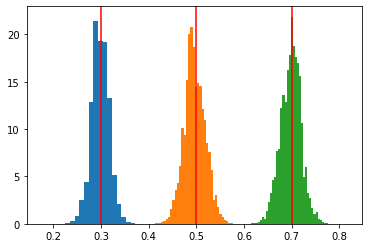

In [14]:
import pylab as plt
for i in range(3):
    s = post_samples['z'][:,i].numpy()
    print(s.std())
    plt.hist(s, bins = 50, density=True);
    plt.axvline(x0[i], color='r')